### Load libraries and functions

In [1]:

import sys
sys.path.insert(0, '../src/')

from load_modify_sample_utils import load_model, get_objective_functions, modify_model, get_reaction_bounds
from load_modify_sample_utils import sample_optgp, sample_dingo, plot_grid_reactions_flux, sampling_statistics

from pathways_utils import sort_reactions_by_model_order, subset_sampling_array_from_reaction_ids, dictionary_reaction_id_to_kegg_id
from pathways_utils import map_model_to_kegg_reactions_dictionary, read_json_file, fill_missing_kegg_ids_in_initial_dictionary
from pathways_utils import get_kegg_pathways_from_reaction_ids, subset_model_reactions_from_pathway_info


### Load and inspect model

In the following chunk, the function `load_model` that loads a metabolic model given in an SBML format is presented.

The function returns 3 objects, 1 metabolic model in cobra format and 2 lists, one with the model reactions and one with their IDs.

The `get_objective_functions` function is used to find and inform the user on the current objective function.
The `get_reaction_bounds` function returns a dictionary with the current bounds of all reactions in the given model.


In [2]:

ec_cobra_model, ec_cobra_reactions, ec_cobra_reaction_ids,  = load_model("../ext_data/models/e_coli_core.xml")

default_objective_functions = get_objective_functions(ec_cobra_model)
print(default_objective_functions)

default_reaction_bounds = get_reaction_bounds(ec_cobra_model)
print(default_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))


Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
['BIOMASS_Ecoli_core_w_GAM']
(0.0, 1000.0)


### Perform FBA on the initial model

Perform a classic FBA analysis to see the initial solution of the objective function

In [3]:

solution = ec_cobra_model.optimize()
print(solution.objective_value)


0.8739215069684302


### Modify the model to create two different conditions

The function `modify_model` modifies a given cobra model.

Users can change objective function, optimal percentage (lower bound of the objective will be fixed based on the optimal percentage),
define custom reaction bounds and change objective direction.

This function enables the user to create metabolic models simulating diffeent conditions. Here, 2 new models are created based on updating the initial model:
- One that maximizes for biomass production (asking at least 100% of the biomass maximum FBA value)
- One that maximize for biomass production (asking at least 0% of the biomass maximum FBA value)


In [4]:

# Set optimal percentage to 100
ec_cobra_model_condition_100 = modify_model(
    cobra_model         = ec_cobra_model,
    objective_function  = "BIOMASS_Ecoli_core_w_GAM",
    optimal_percentage  = 100,
    objective_direction = "max"
)

updated_objective_functions = get_objective_functions(ec_cobra_model_condition_100)
print(updated_objective_functions)

updated_reaction_bounds = get_reaction_bounds(ec_cobra_model_condition_100)
print(updated_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))

# -----------

# Set optimal percentage to 0
ec_cobra_model_condition_0 = modify_model(
    cobra_model         = ec_cobra_model,
    objective_function  = "BIOMASS_Ecoli_core_w_GAM",
    optimal_percentage  = 0,
    objective_direction = "max"
)

updated_objective_functions = get_objective_functions(ec_cobra_model_condition_0)
print(updated_objective_functions)

updated_reaction_bounds = get_reaction_bounds(ec_cobra_model_condition_0)
print(updated_reaction_bounds.get("BIOMASS_Ecoli_core_w_GAM"))


Read LP format model from file /tmp/tmp2d6helcr.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


['BIOMASS_Ecoli_core_w_GAM']
(0.872922, 1000)
Read LP format model from file /tmp/tmpnruiwx5w.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
['BIOMASS_Ecoli_core_w_GAM']
(0.0, 1000)


### Peform FBA on the modified models

Should get the same values if objective function and direction were not changed (as done above)

In [5]:

solution_1 = ec_cobra_model_condition_100.optimize()
print(solution_1.objective_value)


solution_2 = ec_cobra_model_condition_0.optimize()
print(solution_2.objective_value)


0.8739215069684301
0.8739215069684301


### Perform sampling on the 2 models

Sampling using `OptGp` is performed in the following chun using the `sample_optgp` function. Users can change the `n_samples`, `thinning`, parameters:
- `n_samples` defines the number of samples returned to the user.
- `thinning` defines the `thinning` parameter. Default to 100 means samples are returned every 100th step.


In [6]:

samples_optgp_condition_100 = sample_optgp(ec_cobra_model_condition_100, 
                                           n_samples = 3000, 
                                           thinning=100, 
                                           reaction_in_rows = True)


samples_optgp_condition_0 = sample_optgp(ec_cobra_model_condition_0, 
                                         n_samples = 3000, 
                                         thinning=100, 
                                         reaction_in_rows = True)


Read LP format model from file /tmp/tmpdf2j9naf.lp


Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmp_vcfwc37.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


Sampling using dingo is performed in the following chunk. First we load the dingo models corresponding to the 2 cobra models we have using dingo's `from_cobra_model` method. For sampling with the `sample_dingo` function users can change the `ess` and `psrf` parameters:

- `ess` stands for the effective sample size (ESS) (default value is 1000).
- `psrf` is a flag to request an upper bound equal to 1.1 for the value of the potential scale reduction factor of each marginal flux (default option is False).

In [7]:

from dingo import MetabolicNetwork

ec_dingo_model_condition_100 = MetabolicNetwork.from_cobra_model(ec_cobra_model_condition_100)
ec_dingo_model_condition_0 = MetabolicNetwork.from_cobra_model(ec_cobra_model_condition_0)


samples_dingo_condition_100 = sample_dingo(ec_dingo_model_condition_100, 
                                           reaction_in_rows = True, 
                                           ess=1000, 
                                           psrf = False, 
                                           solver="gurobi", 
                                           final_n_samples = None)


samples_dingo_condition_0 =   sample_dingo(ec_dingo_model_condition_0, 
                                           reaction_in_rows = True, 
                                           ess=1000, 
                                           psrf = False, 
                                           solver="gurobi", 
                                           final_n_samples = None)

Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
phase 1: number of correlated samples = 500, effective sample size = 5, ratio of the maximum singilar value over the minimum singular value = 1627.69
phase 2: number of correlated samples = 500, effective sample size = 6, ratio of the maximum singilar value over the minimum singular value = 110.672
phase 3: number of correlated samples = 500, effective sample size = 23, ratio of the maximum singilar value over the minimum singular value = 188.222
phase 4: number of correlated samples = 500, effective sample size = 53, ratio of the maximum singilar value over the minimum singular value = 76.8905
phase 5: number of correlated samples = 500, effective sample size = 176, ratio of the maximum singilar value over the minimum singular value = 3.61376
phase 6: number of correlated samples = 500, effective sample size = 196, ratio of the maximum singilar value over

[5]maximum marginal PSRF: 1.36314


phase 1: number of correlated samples = 500, effective sample size = 15, ratio of the maximum singilar value over the minimum singular value = 1291.37
phase 2: number of correlated samples = 500, effective sample size = 12, ratio of the maximum singilar value over the minimum singular value = 107.262
phase 3: number of correlated samples = 500, effective sample size = 3, ratio of the maximum singilar value over the minimum singular value = 749.326
phase 4: number of correlated samples = 500, effective sample size = 74, ratio of the maximum singilar value over the minimum singular value = 24.066
phase 5: number of correlated samples = 500, effective sample size = 172, ratio of the maximum singilar value over the minimum singular value = 3.01804
phase 6: number of correlated samples = 500, effective sample size = 148, ratio of the maximum singilar value over the minimum singular value = 2.78247
phase 7: number of correlated samples = 2000, effective sample size = 760
[5]total ess 1184: n

[5]maximum marginal PSRF: 1.0212


### Map KEGG pathway information to reactions BiGG ids  

Functions that are used to map information from KEGG pathways to the model reactions (BiGG/SEED ids). For more info see `pathways.ipynb`

In [7]:

initial_bigg_to_kegg_dictionary = map_model_to_kegg_reactions_dictionary(ec_cobra_model)

reactions_json, reactions_pandas = read_json_file("../ext_data/reactions/reactions.json")

bigg_to_kegg, seed_to_kegg = dictionary_reaction_id_to_kegg_id(reactions_pandas)

final_bigg_to_kegg_dictionary = fill_missing_kegg_ids_in_initial_dictionary(initial_bigg_to_kegg_dictionary, 
                                                                            modeltype="BiGG", 
                                                                            bigg_to_kegg=bigg_to_kegg,
                                                                            seed_to_kegg=seed_to_kegg)

df_kegg_pathways = get_kegg_pathways_from_reaction_ids(final_bigg_to_kegg_dictionary)


### Subset sampling dataframe to include only reactions from pathways of interest

This is done to analyze/plot only reactions/pathways of interest.

The `subset_model_reactions_from_pathway_info` function works given a DataFrame created with the `get_kegg_pathways_from_reaction_ids` function and returns all reaction IDs affiliated with a given KEGG pathway name or ID.

The `sort_reactions_by_model_order` function flattens the lists provided in the `subsets` argument (corresponding to reactions from different pathways) in a single list and then orders the element of the new list based on the order of the reaction in the initial model.

The `subset_sampling_array_from_reaction_ids` function takes a sampling array with reactions as rows and samples as columns and subsets it to include only reactions of interest.

In [ ]:

Glycolysis = subset_model_reactions_from_pathway_info(df_kegg_pathways, "Glycolysis / Gluconeogenesis")
PPP = subset_model_reactions_from_pathway_info(df_kegg_pathways, "Pentose phosphate pathway")

reactions_in_pathways_ordered_duplicates = sort_reactions_by_model_order(ec_cobra_reaction_ids, Glycolysis, PPP)


# Remove duplicates
reactions_in_pathways_ordered = []
[reactions_in_pathways_ordered.append(val) for val in reactions_in_pathways_ordered_duplicates if val not in reactions_in_pathways_ordered]


subset_pathways_optgp_condition_100 = subset_sampling_array_from_reaction_ids(
                                                                samples_optgp_condition_100, 
                                                                ec_cobra_reaction_ids, 
                                                                subset_reactions = reactions_in_pathways_ordered)


subset_pathways_optgp_condition_0 = subset_sampling_array_from_reaction_ids(
                                                                samples_optgp_condition_0, 
                                                                ec_cobra_reaction_ids, 
                                                                subset_reactions = reactions_in_pathways_ordered)


### Plot grid of the distributions

This plot enables inspections to the sampling distributions to get early insights.

Left/Right Shifted, Normal, Fixed (transparent based on the `tolerance` parameter) or other Uncommon distributions can be detected.

In the following chunk the grid from glycolysis and ppp pathways resulting from the first sampling dataframe exists

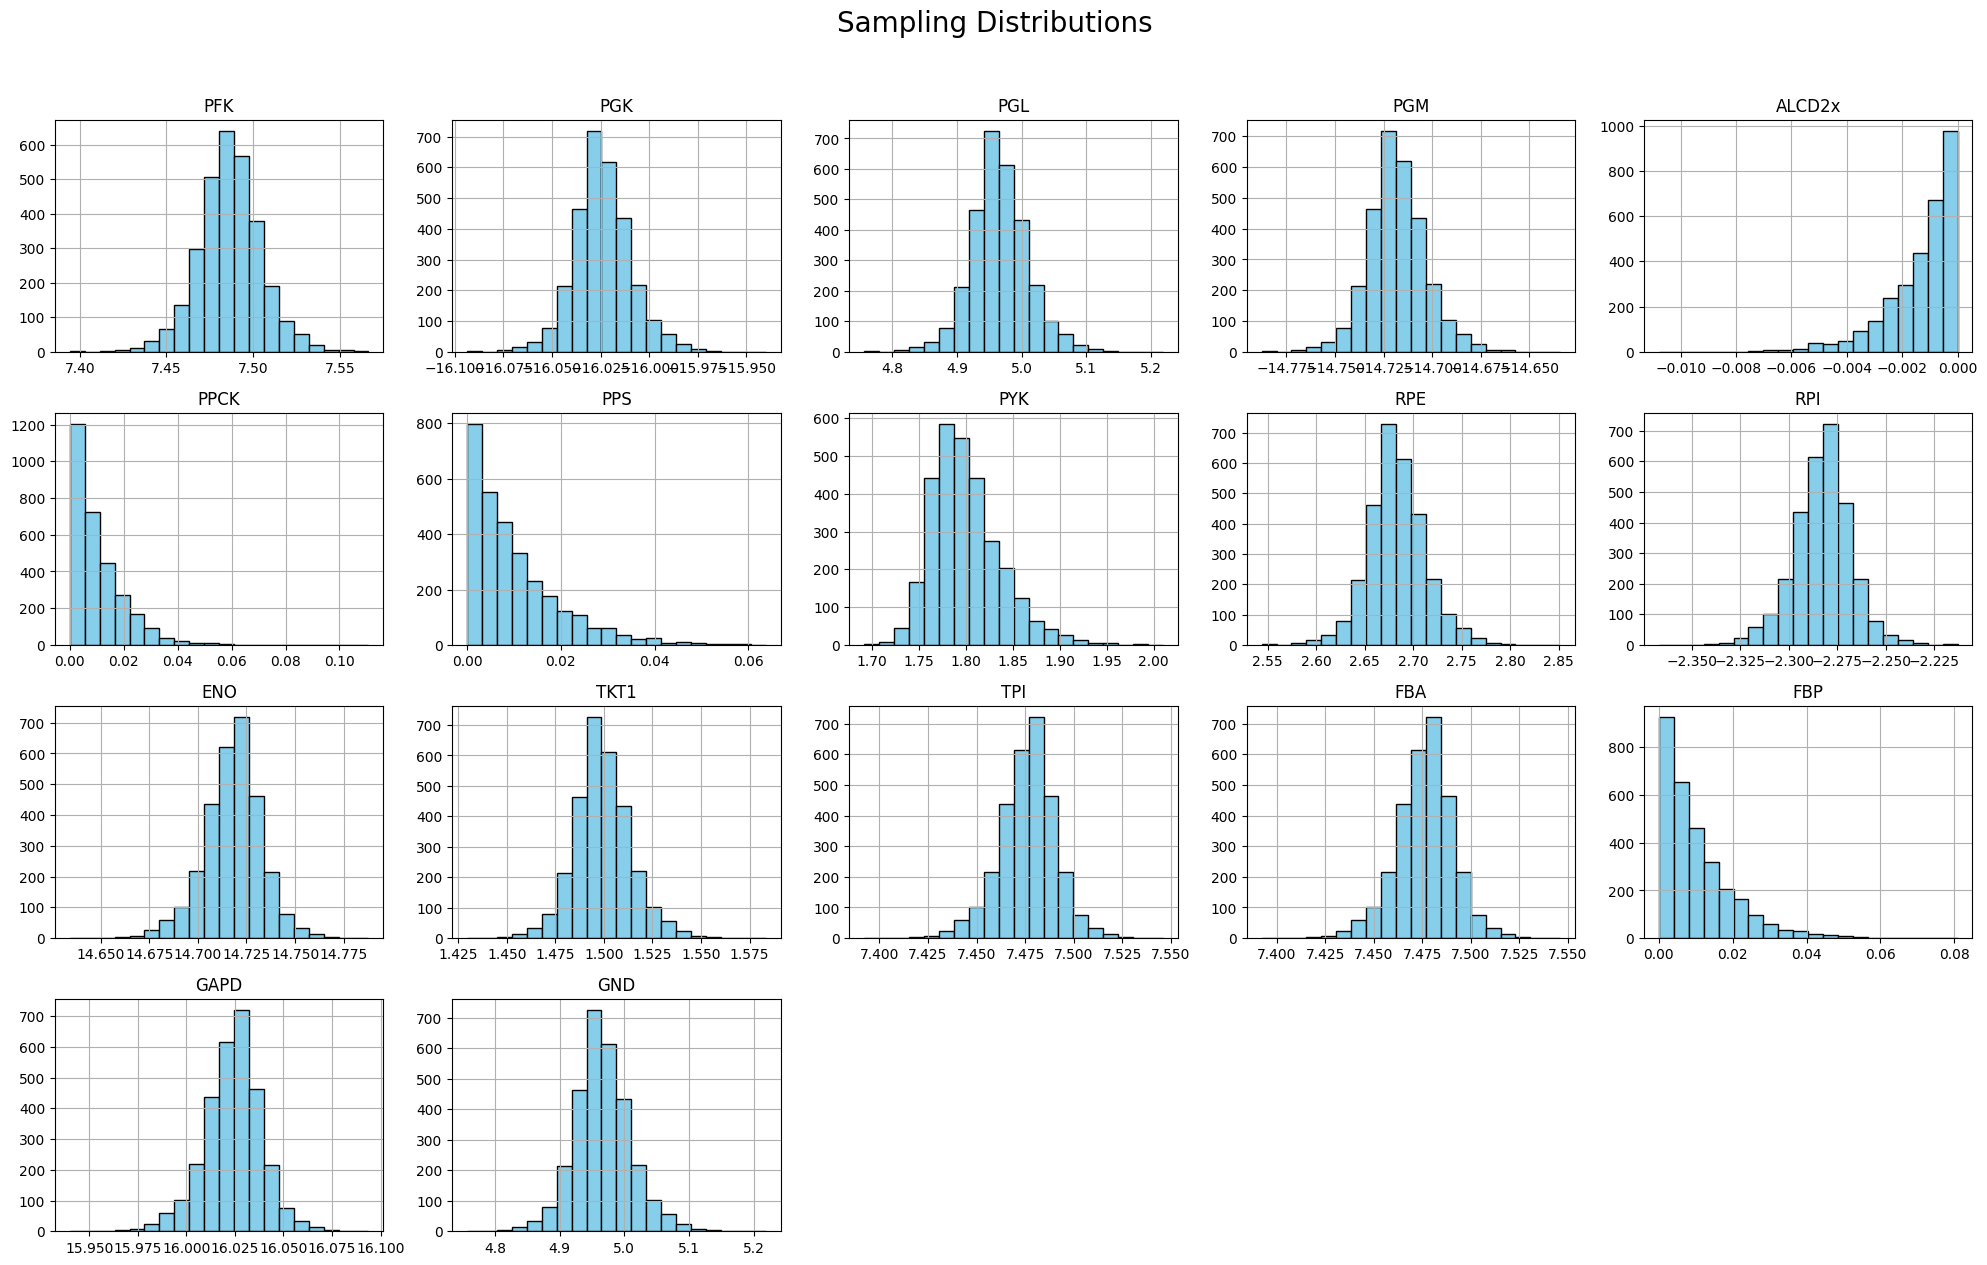

In [10]:

plot_grid_reactions_flux(subset_pathways_optgp_condition_100, 
                         reactions_in_pathways_ordered, 
                         nrows=5, ncols=5,
                         tolerance=1e-3,
                         title="Sampling Distributions")


In the following chunk the grid from glycolysis and ppp pathways resulting from the second sampling dataframe exists

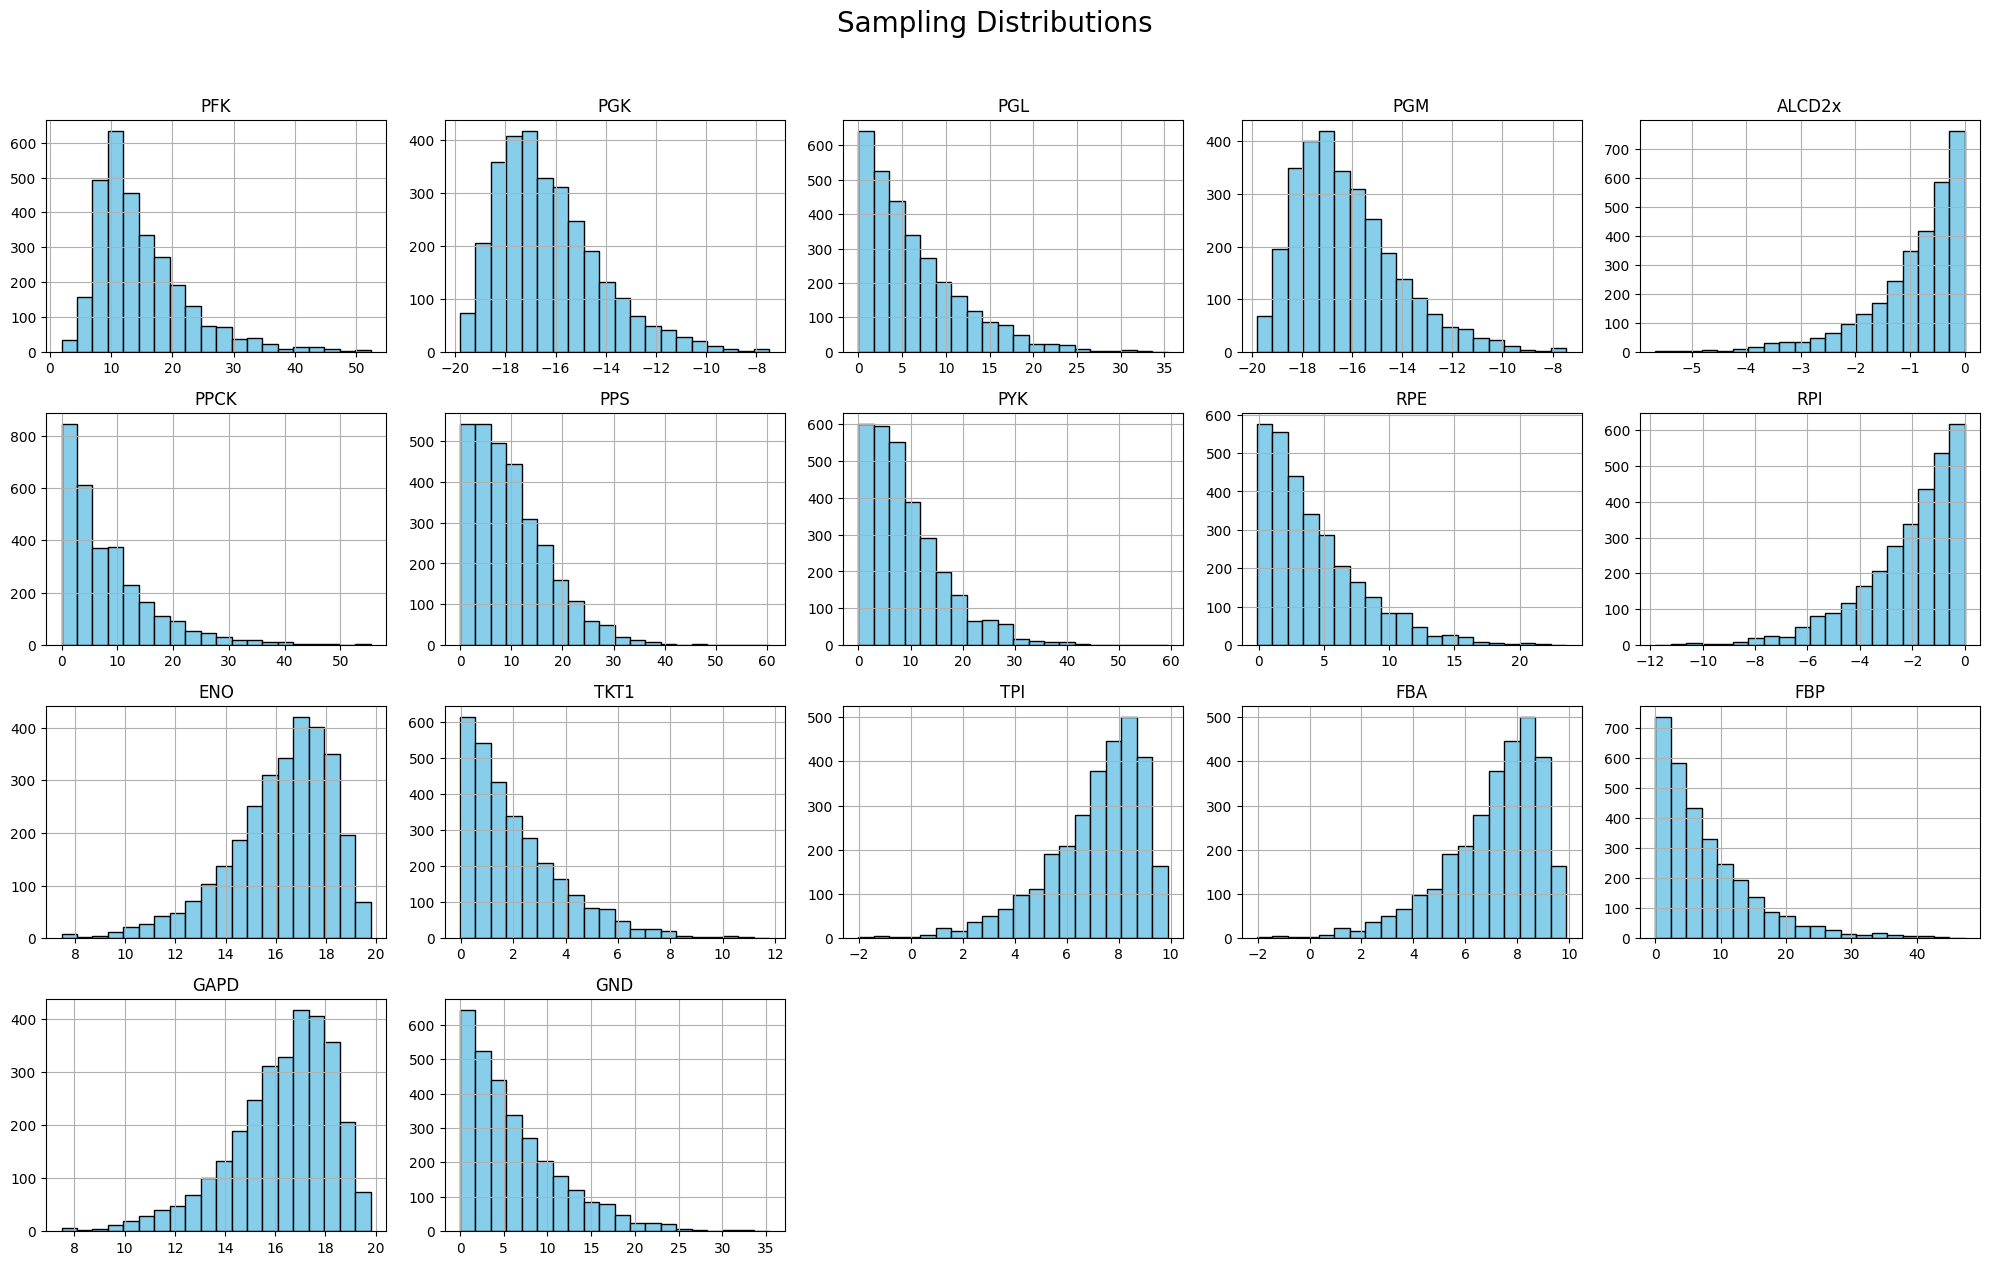

In [11]:

plot_grid_reactions_flux(subset_pathways_optgp_condition_0, 
                         reactions_in_pathways_ordered, 
                         nrows=5, ncols=5,
                         tolerance=1e-3,
                         title="Sampling Distributions")


### Print statistics for reaction of interest

Statistics (e.g. mean, min, max, std, ...) are calculated and printed for each sampling dataframe.

This information can be used to identify significantly altered flux distributions


In [13]:

mean, min, max, std, skewness, kurtosis = sampling_statistics(samples_optgp_condition_100, 
                                                              model_reactions=ec_cobra_reaction_ids,
                                                              reaction_id="FRD7")
print(mean, min, max, std, skewness, kurtosis)


mean, min, max, std, skewness, kurtosis = sampling_statistics(samples_optgp_condition_0,
                                                              model_reactions=ec_cobra_reaction_ids,
                                                              reaction_id="FRD7")
print(mean, min, max, std, skewness, kurtosis)


479.1369619828837 0.14995320273677437 993.9157983127856 289.3315287517938 0.09951034266820558 -1.2064534542990524
474.7669865820229 0.10135434309104707 997.5267773446074 278.80950212031655 0.07570051318545512 -1.1733598969449195
